<a href="https://colab.research.google.com/github/opsabarsec/Receipts-OCR-on-colabs/blob/main/OCR_Receipts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="alert alert-success">
<h1>Detect text/digits on a receipt</h1>
<br><br>    
This script returns the total amount billed from the picture of an invoice. To do so we compare two popular packages, PyTesseract and EasyOCR.
To run those smoothly please activate a GPU runtime.
<br><br>
It works with a neural network model trained on receipt images, according to the procedure described in the paper below
<br><br>    
https://arxiv.org/pdf/1903.12363.pdf
</div>

## 1. Load files and libraries

### 1.1 Install and load libraries

In [1]:
!apt-get update # update repositories of our Ubuntu virtual machine

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:15 http

Tesseract and EasyOCR installation. These are libraries to detect characters/digits

In [2]:
!apt install tesseract-ocr
!apt install libtesseract-dev


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 19 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (5,039 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 146425 files and directories currently installed.)
Preparing to unpack .../tesserac

In [3]:
!pip install opencv-contrib-python 
!pip install pytesseract
!pip install easyocr

  Created wheel for pytesseract: filename=pytesseract-0.3.7-py2.py3-none-any.whl size=13945 sha256=5f37afd8c30fe1773ca8d7bb7d632d7234191d190aa6fac55a6e6e1a623de11d
  Stored in directory: /root/.cache/pip/wheels/81/20/7e/1dd0daad1575d5260916bb1e9781246430647adaef4b3ca3b3
Successfully built pytesseract


#### Import libraries

In [6]:
import easyocr
import pytesseract
from pytesseract import Output
# This Notebook is going to make use of pytesseract which is a wrapper for Google tesseract OCR
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

from skimage import exposure
import numpy as np
import argparse
import imutils

import random
import cv2
import os
from PIL import Image
from glob import glob
import xml.etree.ElementTree as ET
import random
 
 
print("Loaded all libraries")

Loaded all libraries


In [7]:
reader = easyocr.Reader(['en']) # finally import the EasyOCR reader language. English is used in this example.

### 1.2 Download and unzip samples images to train the algorithm

In [8]:
!wget https://expressexpense.com/large-receipt-image-dataset-SRD.zip # download from source

!unzip large-receipt-image-dataset-SRD.zip -d /content/invoice_data/ # exctract to a custom subfolder "invoice_data"

--2021-02-13 08:48:10--  https://expressexpense.com/large-receipt-image-dataset-SRD.zip
Resolving expressexpense.com (expressexpense.com)... 104.26.5.208, 104.26.4.208, 172.67.69.49, ...
Connecting to expressexpense.com (expressexpense.com)|104.26.5.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19230342 (18M) [application/zip]
Saving to: ‘large-receipt-image-dataset-SRD.zip’

large-receipt-image 100%[===================>]  18.34M  17.1MB/s    in 1.1s    

2021-02-13 08:48:11 (17.1 MB/s) - ‘large-receipt-image-dataset-SRD.zip’ saved [19230342/19230342]

Archive:  large-receipt-image-dataset-SRD.zip
  inflating: /content/invoice_data/1078-receipt.jpg  
  inflating: /content/invoice_data/1085-receipt.jpg  
  inflating: /content/invoice_data/1197-receipt.jpg  
  inflating: /content/invoice_data/1008-receipt.jpg  
  inflating: /content/invoice_data/1134-receipt.jpg  
  inflating: /content/invoice_data/1056-receipt.jpg  
  inflating: /content/invoice_data/1144

# 2. Dataset exploration

### 2.1 Files list

In [9]:
# Get file names into a list called "receipt files"
img_dir  = "/content/invoice_data/"
receipt_files = []

for filename in os.listdir(img_dir):
    if filename.endswith("jpg"): 
        # add name to receipt files list 
        receipt_files.append(filename)

print('we have', len(receipt_files), 'pictures of receipts in total')

we have 200 pictures of receipts in total


### 2.2 Example pictures

In [10]:
def show_dir_images(n_to_show):
    plt.figure(figsize=(16,16))
    img_dir = "/content/invoice_data/"
    for i in range(n_to_show):
        img = cv2.imread(img_dir + receipt_files[i])
        plt.subplot(n_to_show/4+1, 4, i+1)
        plt.imshow(img)
        plt.axis('off')


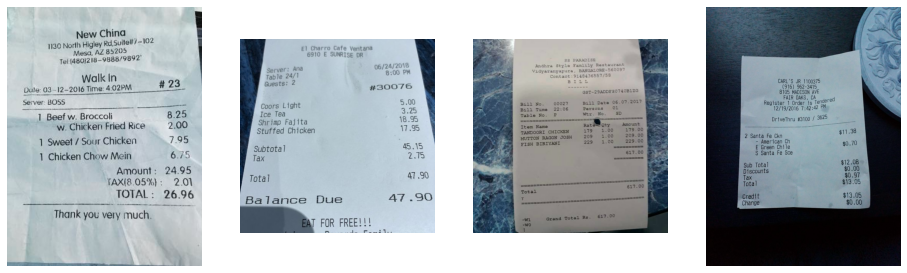

In [11]:
show_dir_images(4)

<div class="alert alert-success">
    Receipts can be bent, we can find handwritings and other objects can be in the picture. Extracting digits is not as easy as in MNIST dataset
</div>

# 3. OCR using Tesseract: extract text from images 

<div class="alert alert-success">
Pytesseract is widely used. In this case we compare its performance with and without image preprocessing using OpenCV 
</div>

In [34]:
#select a random receipt
random_receipt_n = random.randint(0,200)
print(img_dir + receipt_files[random_receipt_n])

/content/invoice_data/1076-receipt.jpg


In [35]:
receipt_example = Image.open(img_dir + receipt_files[random_receipt_n])
print('this is the receipt for OCR')


this is the receipt for OCR


In [36]:
print("image is:",receipt_files[random_receipt_n], "file position in the list is", random_receipt_n)

image is: 1076-receipt.jpg file position in the list is 187


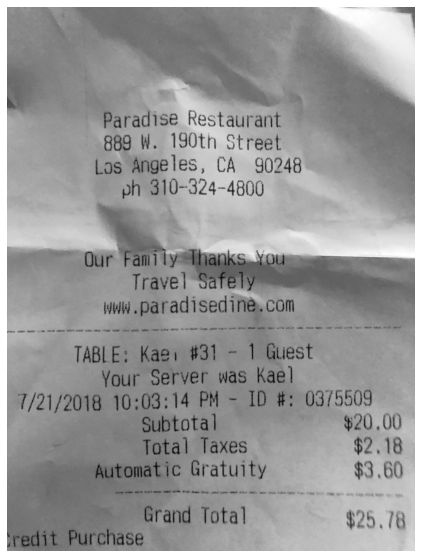

In [37]:
image = cv2.imread(img_dir + receipt_files[random_receipt_n], 0)
# display it
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(image, cmap='Greys_r')

In [38]:
gray, img_bin = cv2.threshold(image,20,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
thresh = cv2.bitwise_not(img_bin)

In [39]:
contours,hierarchy = cv2.findContours(img_bin, 1, 2)
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    if w>100 and h>50:
        break
cropped = img_bin[y:y+h, x:x+w]

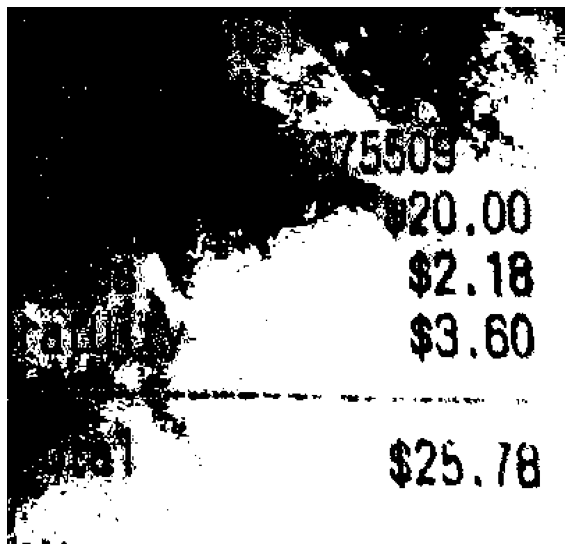

In [40]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(cropped, cmap='Greys_r')

In [41]:
out_cropped = pytesseract.image_to_string(cropped)
out_below = pytesseract.image_to_string(image)
print("OUTPUT:", out_below)
print("OUTPUT cropped image:", out_below)

OUTPUT: adise Restaurant ~~
W. 190th Street
geles, CA 902480 ©
310-324-4800

 

OUTPUT cropped image: adise Restaurant ~~
W. 190th Street
geles, CA 902480 ©
310-324-4800

 



<div class="alert alert-success">
    Tesseract works but has limitation. For example is the image is rotated like for 1039-receipt.jpg characters are not recognized. This can be fixed by augmentation</div>

## 4. OCR using EasyOCR

With EasyOCR we skip preprocessing

In [42]:
easyresult = reader.readtext(image)


In [43]:
for i in range(len(easyresult)):
  print(easyresult[i][1])


Paradise Restaurant
889 ||
I9Oth Street
LJs Angeles
CA
90248
ph 310-324-4800
Our Family Thanks tou
Trave1 Safely
HHli
paradisedine . com
TABLE: Kae
#31
Gtest
Your Server
was Kael
7/21/2018 10:03:14 PM
10 #: 0375509
Subtota1
920.00
Tota1
Taxes
$2,16
Automatic Gratuity
$3,60
Grand Total
124,70
redit Furchase
